## 0. **패키지 임포트**

* conda install -c anaconda py-xgboost
* pip install 

https://lsjsj92.tistory.com/546

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn import metrics 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import eli5 
from eli5.sklearn import PermutationImportance 

In [59]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn import metrics 


## 1. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제
#### 변수
* train : `train.csv`
* test : `test.csv`

In [60]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

## 2. **데이터 셋 확인**


In [61]:
train.info()
test.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [62]:
# 각 유형 갯수 확인
count_type = [0, 0, 0] # object, int64, float64
for col in train.columns:
    if train[col].dtype == 'object':
        count_type[0] += 1
    elif train[col].dtype == 'int64':
        count_type[1] += 1
    elif train[col].dtype == 'float64':
        count_type[2] += 1
display(count_type)

[8, 7, 4]

#### object 8개, int64 7개 , float64 4개 있음.
-------------------------

## 3. **결측치 처리**
* 결측치는 직업 유형에만 존재함 -> 'unfilled'로 대체함. 
* 향후 '직업 유형의 결측치를 어떻게 해결할 것 인가' 고민이 필요함.

In [63]:
test['occyp_type'].count

<bound method Series.count of 0                  NaN
1           Core staff
2             Laborers
3              Drivers
4             Managers
             ...      
9995       Accountants
9996          Laborers
9997    Medicine staff
9998               NaN
9999          Laborers
Name: occyp_type, Length: 10000, dtype: object>

In [64]:
test['occyp_type'].isnull().sum()

3152

In [65]:
# 결측치 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

훈련데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64
테스트데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


In [66]:
# 결측치 처리
#print()
#train['occyp_type'].fillna('unfilled', inplace=True) # 직업 유형 경우, 결측치가 많아서 따로 'unfilled' 라고 채움
#test['occyp_type'].fillna('unfilled', inplace=True)

cond = (train['income_type'] == 'Pensioner')
train['occyp_type'] = train['occyp_type'].fillna(cond.map({True:'Retired', False: 'NaN'}))

cond = (test['income_type'] == 'Pensioner')
test['occyp_type'] = test['occyp_type'].fillna(cond.map({True:'Retired', False: 'NaN'}))

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

display(train)
display(test)

훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,Retired,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


## 3. **이상치 처리**
* 정수형, 실수형 데이터에서 이상치 찾아보고, 그에 맞게 처리하자.

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**
* 정수/실수형 데이터를 가진 10개 컬럼 중 휴대전화/직장전화/가정용전화/이메일 보유여부는 이상치 없음. (1아니면 0이니깐)
* 이 외에 6개 컬럼들 하나씩 살펴보기
 * 6개: 자녀 수, 가족 규모, 연간 소득, 출생일, 업무 시작일, 신용카드 발급 월 
 * 또한 분석하기 용이하게 데이터 변경 (ex) 부호 변환 or 일 수를 나이로)

#### 1) 자녀 수
* 2명 -> 3명 -> 4명. 

In [67]:
print('train childnum unique:', train['child_num'].unique())

train childnum unique: [ 0  1  2  3  4  5 14 19  7]


childnum unique: [0 1 2 3 4 5]


<AxesSubplot:xlabel='child_num'>

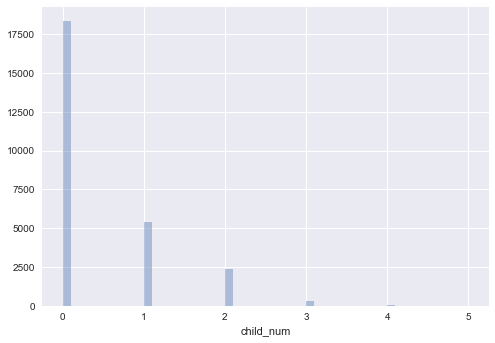

In [68]:
# 아이가 6명 이상인 데이터는 5로 변경
train.loc[train['child_num'] >= 6,'child_num'] = 5
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

#### 2) 가족 규모

In [69]:
print('train familysize unique:', train['family_size'].unique())

train familysize unique: [ 2.  3.  4.  1.  5.  6.  7. 15. 20.  9.]


In [70]:
# 가족규모가 7명 이상인 데이터는 6로 변경
train.loc[train['family_size'] >= 8,'family_size']=7

train familysize unique: [2. 3. 4. 1. 5. 6. 7.]


<AxesSubplot:xlabel='family_size'>

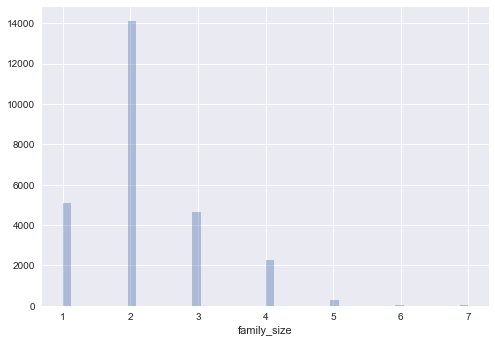

In [71]:
print('train familysize unique:', train['family_size'].unique())
sns.distplot(train['family_size'], kde=False, label='family_size')

#### 3) 연간 소득

Text(0.5, 1.0, 'test Boxplot of income_total')

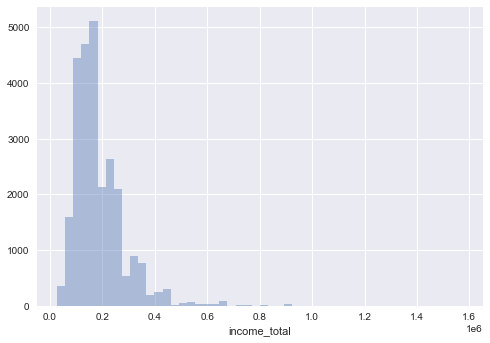

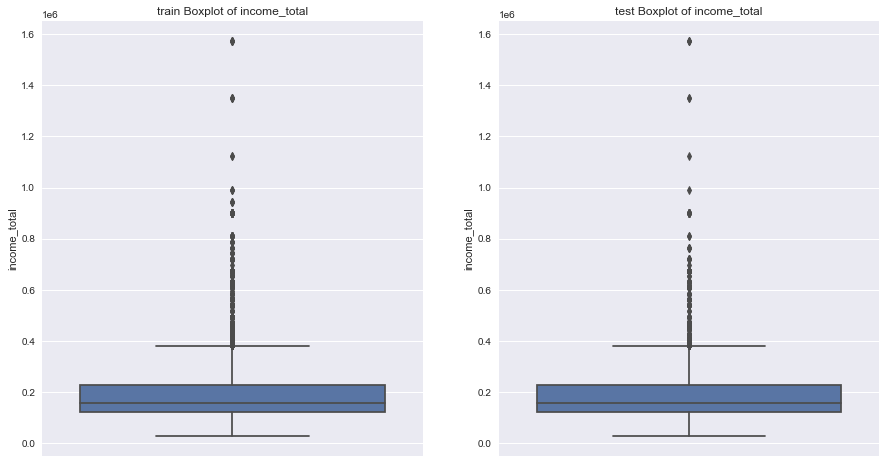

In [72]:
sns.distplot(train['income_total'], kde=False, label='income_total')
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("train Boxplot of income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("test Boxplot of income_total")

#### 4) 출생일
* 양수 변환

In [73]:
def days_to_age(x):
    return (x*-1)

# train
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(train['DAYS_BIRTH'])

# test
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(test['DAYS_BIRTH'])

0        13899
1        11380
2        19087
3        15088
4        15037
         ...  
26452    12079
26453    15291
26454    10082
26455    10145
26456    19569
Name: DAYS_BIRTH, Length: 26457, dtype: int32

0       21990
1       18964
2       15887
3       19270
4       17822
        ...  
9995    18593
9996    10886
9997    21016
9998    16541
9999     9154
Name: DAYS_BIRTH, Length: 10000, dtype: int32

#### 5) 업무시작일 -> 업무 연차
* 양수 변환
    * 단, 365243은 0으로 변환

In [74]:
def days_to_year(x):
    if x==365243 :
        return 0
    return (x*-1)

# train
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(train['DAYS_EMPLOYED'])

# test
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(test['DAYS_EMPLOYED'])

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 26457, dtype: int32

0           0
1        8671
2         217
3        2531
4        9385
        ...  
9995     5434
9996     1315
9997    14018
9998     1085
9999      187
Name: DAYS_EMPLOYED, Length: 10000, dtype: int32

#### 6) 신용카드 발급 월

* 양수로 변환

In [75]:
def minus(x):
    return x * -1

# train
train['begin_month'] = train['begin_month'].apply(minus)
display(train['begin_month'])

# test
test['begin_month'] = test['begin_month'].apply(minus)
display(test['begin_month'])

0         6.0
1         5.0
2        22.0
3        37.0
4        26.0
         ... 
26452     2.0
26453    47.0
26454    25.0
26455    59.0
26456     9.0
Name: begin_month, Length: 26457, dtype: float64

0       60.0
1       36.0
2       40.0
3       41.0
4        8.0
        ... 
9995    19.0
9996    34.0
9997    55.0
9998    33.0
9999    11.0
Name: begin_month, Length: 10000, dtype: float64

## 4. **Feature Engineering**

* 수치형 컬럼은 기존 데이터 분포와 비슷하고, 어느정도 일정한 범위를 갖게 정규화해야함
* 각 컬럼마다 동일한 스케일러 적용할 필요는 없음. 
* [다른 스케일러 적용한 사례- 블로그](https://lsjsj92.tistory.com/555?category=853217)

### 4-1. 범주형 데이터 one-hot encoding, label encoding
* object (범주형)은 원핫인코딩 하기.
    * 단, occyp_type은 라벨 인코딩.
* 범주형 데이터를 가지는 변수 확인 (dtype가 object)
* gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [76]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object' : # and col!='occyp_type': # 변수가 18개인 occyp_type만 제외
        object_col.append(col)
display(object_col)

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [77]:
print(train['occyp_type'].unique())
(len(train['occyp_type'].unique()))

['NaN' 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Retired'
 'Realty agents' 'Security staff' 'Cleaning staff' 'Private service staff'
 'Cooking staff' 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']


20

#### 4-1-1. train의 원핫인코딩, 라벨인코딩

In [78]:
# occyp_type을 제외한 모든 object객체 열을 onehot encoding

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [79]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# train['occyp_type']=label_encoder.fit_transform(train['occyp_type'])

In [80]:
# 인코딩 확인

display(train.head(5))
print(train.columns)
train.info()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0,202500.0,13899,4709,1,0,0,0,2.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,247500.0,11380,1540,1,0,0,1,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,450000.0,19087,4434,1,0,1,0,2.0,22.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,202500.0,15088,2092,1,0,1,0,2.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,157500.0,15037,2105,1,0,0,0,2.0,26.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'credit', 'gender_F', 'gender_M', 'car_N', 'car_Y',
       'reality_N', 'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'edu_type_Academic degree', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'edu_type_Secondary / secondary special', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp

#### 4-1-2. test의 원핫인코딩, 라벨인코딩

In [81]:
# occyp_type을 제외한 모든 object객체 열을  onehot encoding
enc = OneHotEncoder()
enc.fit(test.loc[:,object_col])

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [82]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# test['occyp_type']=label_encoder.fit_transform(test['occyp_type'])

In [83]:
# 인코딩 확인

display(test)
print(test.columns)
test.info()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0,112500.0,21990,0,1,0,1,0,2.0,60.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,135000.0,18964,8671,1,0,1,0,2.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,69372.0,15887,217,1,1,1,0,2.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,112500.0,19270,2531,1,1,0,0,2.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,225000.0,17822,9385,1,1,0,0,2.0,8.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,202500.0,18593,5434,1,1,1,0,2.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0,202500.0,10886,1315,1,1,0,0,2.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0,292500.0,21016,14018,1,0,0,0,2.0,55.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0,180000.0,16541,1085,1,0,1,0,2.0,33.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size',
       'begin_month', 'gender_F', 'gender_M', 'car_N', 'car_Y', 'reality_N',
       'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'edu_type_Academic degree', 'edu_type_Higher education',
       'edu_type_Incomplete higher', 'edu_type_Lower secondary',
       'edu_type_Secondary / secondary special', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Accountants', 'occyp_type_Cleaning staff',
       'occyp_type_Cook

### 4-2. 데이터 정규화

#### 4-2-1. MinMaxScaler

In [84]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler_data = train.drop(['credit'], axis=1)

minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(MinMaxScaler_data))
train_data_minMaxScaled = minMaxScaler.transform(MinMaxScaler_data)

# MinMaxScaler_data - MinMaxScaler적용한 데이터 프레임
index = 0
for col in MinMaxScaler_data.columns :
    MinMaxScaler_data[col] = train_data_minMaxScaled[:,index]
    index = index + 1
display(MinMaxScaler_data)



# test.csv 정규화
# testSet = test.copy()
# test_data = minMaxScaler.transform(testSet)

# display(test)
# display(testSet)

# index = 0
# for col in testSet.columns :
#     testSet[col] = test_data[:,index]
#     index = index + 1
# display(testSet)

MinMaxScaler()


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0.0,0.113372,0.355018,0.299688,0.0,0.0,0.0,0.0,0.166667,0.100000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2,0.142442,0.210638,0.098008,0.0,0.0,0.0,1.0,0.333333,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.273256,0.652376,0.282187,0.0,0.0,1.0,0.0,0.166667,0.366667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.113372,0.423167,0.133138,0.0,0.0,1.0,0.0,0.166667,0.616667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.084302,0.420244,0.133966,0.0,0.0,0.0,0.0,0.166667,0.433333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.4,0.127907,0.250702,0.126265,0.0,0.0,0.0,0.0,0.500000,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26453,0.2,0.098837,0.434803,0.157513,0.0,0.0,0.0,0.0,0.166667,0.783333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26454,0.0,0.171512,0.136241,0.128238,0.0,0.0,0.0,0.0,0.166667,0.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26455,0.0,0.093023,0.139852,0.006810,0.0,0.0,0.0,0.0,0.000000,0.983333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 4-2-2 MaxAbsScaler

In [85]:
from sklearn.preprocessing import MaxAbsScaler

MaxAbsScaler_data = train.drop(['credit'], axis=1)

maxAbsScaler = MaxAbsScaler()
print(maxAbsScaler.fit(MaxAbsScaler_data))
train_data_maxAbsScaled = maxAbsScaler.transform(MaxAbsScaler_data)

# MaxAbsScaler_data - MaxAbsScaler 적용한 데이터 프레임
index = 0
for col in MaxAbsScaler_data.columns :
    MaxAbsScaler_data[col] = train_data_maxAbsScaled[:,index]
    index = index + 1
display(MaxAbsScaler_data)


# test.csv 정규화
# testSet = test.copy()
# test_data = maxAbsScaler.transform(testSet)

# display(test)
# display(testSet)

# index = 0
# for col in testSet.columns :
#     testSet[col] = test_data[:,index]
#     index = index + 1
# display(testSet)

MaxAbsScaler()


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0.0,0.128571,0.552600,0.299688,1.0,0.0,0.0,0.0,0.285714,0.100000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2,0.157143,0.452449,0.098008,1.0,0.0,0.0,1.0,0.428571,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.285714,0.758866,0.282187,1.0,0.0,1.0,0.0,0.285714,0.366667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.128571,0.599873,0.133138,1.0,0.0,1.0,0.0,0.285714,0.616667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.100000,0.597845,0.133966,1.0,0.0,0.0,0.0,0.285714,0.433333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.4,0.142857,0.480240,0.126265,1.0,0.0,0.0,0.0,0.571429,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26453,0.2,0.114286,0.607944,0.157513,1.0,0.0,0.0,0.0,0.285714,0.783333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26454,0.0,0.185714,0.400843,0.128238,1.0,0.0,0.0,0.0,0.285714,0.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26455,0.0,0.108571,0.403348,0.006810,1.0,0.0,0.0,0.0,0.142857,0.983333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 4-2-3 StandardScaler

In [114]:
from sklearn.preprocessing import StandardScaler

StandardScaler_data = train.drop(['credit'], axis=1)

standardScaler = StandardScaler()
print(standardScaler.fit(StandardScaler_data))
train_data_standardScaled = standardScaler.transform(StandardScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in StandardScaler_data.columns :
    StandardScaler_data[col] = train_data_standardScaled[:,index]
    index = index + 1
display(StandardScaler_data)

# test.csv 정규화
# testSet = test.copy()
# test_data = standardScaler.transform(testSet)

# display(test)
# display(testSet)

# index = 0
# for col in testSet.columns :
#     testSet[col] = test_data[:,index]
#     index = index + 1
# display(testSet)

StandardScaler()


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,-0.588681,0.149136,-0.490075,1.059227,0.0,-0.538417,-0.645705,-0.316937,-0.216797,-1.215231,...,-0.298687,-0.183737,2.468021,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622
1,0.790102,0.590848,-1.089621,-0.277849,0.0,-0.538417,-0.645705,3.155199,0.893286,-1.275620,...,-0.298687,-0.183737,-0.405183,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622
2,-0.588681,2.578550,0.744719,0.943198,0.0,-0.538417,1.548696,-0.316937,-0.216797,-0.249003,...,3.347991,-0.183737,-0.405183,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622
3,-0.588681,0.149136,-0.207081,-0.044947,0.0,-0.538417,1.548696,-0.316937,-0.216797,0.656836,...,-0.298687,-0.183737,-0.405183,-0.09628,-0.048856,-0.449068,3.069242,-0.060662,-0.127621,-0.068622
4,-0.588681,-0.292575,-0.219220,-0.039462,0.0,-0.538417,-0.645705,-0.316937,-0.216797,-0.007446,...,3.347991,-0.183737,-0.405183,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2.168885,0.369992,-0.923252,-0.090515,0.0,-0.538417,-0.645705,-0.316937,2.003368,-1.456788,...,-0.298687,-0.183737,-0.405183,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622
26453,0.790102,-0.071719,-0.158765,0.116649,0.0,-0.538417,-0.645705,-0.316937,-0.216797,1.260729,...,-0.298687,-0.183737,2.468021,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622
26454,-0.588681,1.032559,-1.398558,-0.077435,0.0,-0.538417,-0.645705,-0.316937,-0.216797,-0.067835,...,-0.298687,-0.183737,-0.405183,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622
26455,-0.588681,-0.160062,-1.383563,-0.882466,0.0,-0.538417,-0.645705,-0.316937,-1.326880,1.985400,...,-0.298687,-0.183737,-0.405183,-0.09628,-0.048856,-0.449068,-0.325813,-0.060662,-0.127621,-0.068622


#### 4-2-4 RobustScaler

In [86]:
from sklearn.preprocessing import RobustScaler

RobustScaler_data = train.drop(['credit'], axis=1)

robustScaler = RobustScaler()
print(robustScaler.fit(RobustScaler_data))
train_data_robustScaled = robustScaler.transform(RobustScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in RobustScaler_data.columns :
    RobustScaler_data[col] = train_data_robustScaled[:,index]
    index = index + 1
display(RobustScaler_data)

# test.csv 정규화
testSet = test.copy()
test_data = robustScaler.transform(testSet)

display(test)
display(testSet)

index = 0
for col in testSet.columns :
    testSet[col] = test_data[:,index]
    index = index + 1
display(testSet)

RobustScaler()


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0.0,0.434783,-0.235934,1.154406,0.0,0.0,0.0,0.0,0.0,-0.666667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.869565,-0.596564,0.000364,0.0,0.0,0.0,1.0,1.0,-0.703704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.826087,0.506800,1.054261,0.0,0.0,1.0,0.0,0.0,-0.074074,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.434783,-0.065712,0.201384,0.0,0.0,1.0,0.0,0.0,0.481481,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.000000,-0.073014,0.206118,0.0,0.0,0.0,0.0,0.0,0.074074,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2.0,0.652174,-0.496492,0.162054,0.0,0.0,0.0,0.0,2.0,-0.814815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26453,1.0,0.217391,-0.036650,0.340859,0.0,0.0,0.0,0.0,0.0,0.851852,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26454,0.0,1.304348,-0.782391,0.173343,0.0,0.0,0.0,0.0,0.0,0.037037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26455,0.0,0.130435,-0.773372,-0.521486,0.0,0.0,0.0,0.0,-1.0,1.296296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0,112500.0,21990,0,1,0,1,0,2.0,60.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,135000.0,18964,8671,1,0,1,0,2.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,69372.0,15887,217,1,1,1,0,2.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,112500.0,19270,2531,1,1,0,0,2.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,225000.0,17822,9385,1,1,0,0,2.0,8.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,202500.0,18593,5434,1,1,1,0,2.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0,202500.0,10886,1315,1,1,0,0,2.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0,292500.0,21016,14018,1,0,0,0,2.0,55.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0,180000.0,16541,1085,1,0,1,0,2.0,33.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0,112500.0,21990,0,1,0,1,0,2.0,60.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,135000.0,18964,8671,1,0,1,0,2.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,69372.0,15887,217,1,1,1,0,2.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,112500.0,19270,2531,1,1,0,0,2.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,225000.0,17822,9385,1,1,0,0,2.0,8.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,202500.0,18593,5434,1,1,1,0,2.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0,202500.0,10886,1315,1,1,0,0,2.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0,292500.0,21016,14018,1,0,0,0,2.0,55.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0,180000.0,16541,1085,1,0,1,0,2.0,33.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0.0,-0.434783,0.922405,-0.560452,0.0,0.0,1.0,0.0,0.0,1.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,-0.217391,0.489191,2.597232,0.0,0.0,1.0,0.0,0.0,0.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.851478,0.048676,-0.481428,0.0,1.0,1.0,0.0,0.0,0.592593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.434783,0.532999,0.361253,0.0,1.0,0.0,0.0,0.0,0.629630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.652174,0.325698,2.857247,0.0,1.0,0.0,0.0,0.0,-0.592593,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.434783,0.436077,1.418427,0.0,1.0,1.0,0.0,0.0,-0.185185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.434783,-0.667287,-0.081573,0.0,1.0,0.0,0.0,0.0,0.370370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,1.304348,0.782963,4.544428,0.0,0.0,0.0,0.0,0.0,1.148148,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.217391,0.142305,-0.165331,0.0,0.0,1.0,0.0,0.0,0.333333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----------------------------------------------
## 여기까지 정규화, 이상치 처리 완료해야 함, 데이터 전처리 단계

#### 정규화한 데이터 이름
* MinMaxScaler_data
* MaxAbsScaler_data
* StandardScaler_data
* RobustScaler_data

## 5. 모델링

### 5-0 데이터 분리
* 데이터 분리는 stratifiedKFold를 사용하여 y값 분포를 비슷하게 분리 시킴 -> 5-fold
    * StratifiedKFold(계층별 k-겹 교차검증) - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
    * 타겟에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지
    * 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함
* n_split는 몇 개로 분할할지 결정
* shtffle은 데이터 섞어서 샘플의 순서 랜덤하게. 
* 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수있음
* 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라짐

In [87]:
# 설명변수 X, 예측변수 y 할당 (사용하고자하는 정규화 스케일러로 변경 가능)
X = RobustScaler_data
Y = train['credit']

X = X.drop(['child_num'], axis=1)
testSet = testSet.drop(['child_num'], axis=1)

In [88]:
display(X)
display(testSet)

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,gender_F,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0.434783,-0.235934,1.154406,0.0,0.0,0.0,0.0,0.0,-0.666667,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.869565,-0.596564,0.000364,0.0,0.0,0.0,1.0,1.0,-0.703704,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.826087,0.506800,1.054261,0.0,0.0,1.0,0.0,0.0,-0.074074,-1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.434783,-0.065712,0.201384,0.0,0.0,1.0,0.0,0.0,0.481481,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,-0.073014,0.206118,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.652174,-0.496492,0.162054,0.0,0.0,0.0,0.0,2.0,-0.814815,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26453,0.217391,-0.036650,0.340859,0.0,0.0,0.0,0.0,0.0,0.851852,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26454,1.304348,-0.782391,0.173343,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26455,0.130435,-0.773372,-0.521486,0.0,0.0,0.0,0.0,-1.0,1.296296,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,gender_F,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,-0.434783,0.922405,-0.560452,0.0,0.0,1.0,0.0,0.0,1.333333,-1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.217391,0.489191,2.597232,0.0,0.0,1.0,0.0,0.0,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.851478,0.048676,-0.481428,0.0,1.0,1.0,0.0,0.0,0.592593,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.434783,0.532999,0.361253,0.0,1.0,0.0,0.0,0.0,0.629630,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.652174,0.325698,2.857247,0.0,1.0,0.0,0.0,0.0,-0.592593,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.434783,0.436077,1.418427,0.0,1.0,1.0,0.0,0.0,-0.185185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.434783,-0.667287,-0.081573,0.0,1.0,0.0,0.0,0.0,0.370370,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,1.304348,0.782963,4.544428,0.0,0.0,0.0,0.0,0.0,1.148148,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.217391,0.142305,-0.165331,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
folds=[]

# 계층별 k-겹 교차검증을 위해 인덱스를 나누는 코드
for train_index, valid_index in skf.split(train, train['credit']):
    folds.append((train_index, valid_index))
display(folds)

[(array([    0,     1,     3, ..., 26453, 26454, 26456]),
  array([    2,    26,    45, ..., 26446, 26452, 26455])),
 (array([    2,     3,     6, ..., 26454, 26455, 26456]),
  array([    0,     1,     4, ..., 26435, 26447, 26450])),
 (array([    0,     1,     2, ..., 26453, 26454, 26455]),
  array([    3,    12,    16, ..., 26438, 26448, 26456])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([    6,    14,    29, ..., 26440, 26442, 26453])),
 (array([    0,     1,     2, ..., 26453, 26455, 26456]),
  array([    7,     9,    10, ..., 26449, 26451, 26454]))]

* 여기서 앞으로 계속 사용할 X,Y, folds 저장되어 있음

### 5-1. LGBM
[LGBM 모델 설명](https://lsjsj92.tistory.com/548)
#### Training    
* LGBM의 기본 파라미터로 훈련
* 30번 이상 개선 없을 경우 중단.
* 각 5개의 fold를 훈련하여 저장

In [90]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    
    y_hat = lgb.predict(X_valid)
    lgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(lgb_matrix)
    lgb_report = metrics.classification_report(Y_valid, y_hat)
    print(lgb_report)
    lgb_models[fold]=lgb
    
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.651696	valid_1's multi_logloss: 0.751014
[200]	training's multi_logloss: 0.569705	valid_1's multi_logloss: 0.738794
[300]	training's multi_logloss: 0.505899	valid_1's multi_logloss: 0.732894
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.516425	valid_1's multi_logloss: 0.73255
[[  72   81  492]
 [  22  418  814]
 [  39  101 3253]]
              precision    recall  f1-score   support

         0.0       0.54      0.11      0.19       645
         1.0       0.70      0.33      0.45      1254
         2.0       0.71      0.96      0.82      3393

    accuracy                           0.71      5292
   macro avg       0.65      0.47      0.48      5292
weighted avg       0.69      0.71      0.65      5292



====================================2============================================
Tra

#### Test inference
* 각 폴드를 훈련시킨 LGBM으로 예측
* 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함
* 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
* predict는 class 출력을 해주고 predict_proba는 class 별 probability를 출력해줌
* predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블함

In [91]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(testSet)/5
submit.to_csv('./LGBM_retire_0425.csv', index=False) # 0.7272812144
submit.head(20)

,index,0,1,2
0,26457,0.061787,0.120301,0.817912
1,26458,0.179156,0.166499,0.654346
2,26459,0.053160,0.120156,0.826684
3,26460,0.095546,0.131803,0.772651
4,26461,0.081367,0.170809,0.747824
5,26462,0.072670,0.160111,0.767219
6,26463,0.530840,0.468703,0.000457
7,26464,0.124823,0.146191,0.728987
8,26465,0.065994,0.131629,0.802376
9,26466,0.056752,0.257764,0.685484


### 5-2. **로지스틱 회귀분석**

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

random.seed(42)
logR_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    logmodel = LogisticRegression()
    logmodel.fit(X_train, Y_train)  
    y_hat = logmodel.predict(X_valid)
    
    logR_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(logR_matrix)
    logR_report = metrics.classification_report(Y_valid, y_hat)
    print(logR_report)
    
    print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
    print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')
    logR_models[fold]=logmodel
    print(f'================================================================================\n\n')

====================================1============================================
[[   0    5  640]
 [   0    6 1248]
 [   0    4 3389]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.40      0.00      0.01      1254
         2.0       0.64      1.00      0.78      3393

    accuracy                           0.64      5292
   macro avg       0.35      0.33      0.26      5292
weighted avg       0.51      0.64      0.50      5292

학습용 데이터셋 정확도 : 0.64276
검증용 데이터셋 정확도 : 0.64153
Log Loss: 0.866692


====================================2============================================
[[   0    4  641]
 [   0    7 1247]
 [   0    2 3391]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.54      0.01      0.01      1254
         2.0       0.64      1.00      0.78      3393

    accuracy                           0.64      5292
   mac

KeyboardInterrupt: 

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += logR_models[fold].predict_proba(testSet)/5

submit.to_csv('./logR_0425.csv', index=False)
submit.head(20)

In [ ]:
# from sklearn.metrics import classification_report
# y_pred=log.predict(X_test)
# print(classification_report(y_test, y_pred))

# 아래 결과는 md파일 참고
# print(log.predict_proba(test))

### 5-3 KNN

In [ ]:
# # 시간 진 ~ 짜 오래걸리니까 ... 변한거 없으면 그냥 돌리지 마세요 ....!

# # 최적 k 도출 - Cross Validation 이용
# from sklearn.model_selection import cross_val_score
# from sklearn.neighbors import KNeighborsClassifier

# k_range = range(1,50) # 1~100 에서 최적 k 찾기
# k_scores = []

# for k in k_range :
#     print(k)
#     knn = KNeighborsClassifier(k)
#     scores = cross_val_score(knn, X, y, cv=10, scoring = "accuracy") # 10-fold cross validation
#     k_scores.append(scores.mean())
    

# # 최적 k를 그래프로 확인    
# plt.plot(k_range, k_scores)
# plt.xlabel('value of K for KNN')
# plt.ylabel('Cross_Validation Accuracy')
# plt.show()

# # k_scores 리스트에서 최댓값의 index 구하기 (최적 k 찾기)
# k = k_scores.index(max(k_scores)) + 1
# print(k)

In [ ]:
random.seed(42)

# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn import metrics 

knn_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # knn 모델
    knn = KNeighborsClassifier(n_neighbors=75) # 75로 해놓음
    knn.fit(X_train, Y_train)
    y_hat = knn.predict(X_valid)
    
    knn_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(knn_matrix)
    
    knn_report = metrics.classification_report(Y_valid, y_hat)
    print(knn_report)

    print(log_loss(Y_valid, knn.predict_proba(X_valid)))

    knn_models[fold]=knn
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += knn_models[fold].predict_proba(testSet)/5

submit.to_csv('./knn_0422.csv', index=False)
submit.head(20)

In [ ]:
# # 최적 k로 모델 학습
# # sklearn 라이브러리에서 KNN 분류 모형 가져오기
# from sklearn.neighbors import KNeighborsClassifier

# # 모형 객체 생성 (최적 k 사용)
# knn = KNeighborsClassifier(n_neighbors=75) # 75로 해놓음

# # train data를 가지고 모형 학습
# knn.fit(X_train, y_train)

# # test data를 가지고 예측(분류)하고 예측값을 y_hat에 저장
# y_hat = knn.predict(X_test)

# # 시각적으로 확인해보기
# print(y_hat[0:10])
# print(y_test.values[0:10])

### 5-4. SVM

In [ ]:
random.seed(42)

SVM_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    svm_model = svm.SVC(C=1, gamma = 10, kernel='rbf', probability=True)
    svm_model.fit(X_train, Y_train)   
    y_hat = svm_model.predict(X_valid)
    svm_matrix = metrics.confusion_matrix(Y_valid, y_hat)  
    print(svm_matrix)
    print('\n')
    svm_report = metrics.classification_report(Y_valid, y_hat)            
    print(svm_report)
    print(svm_model.predict_proba(X_valid))
    print('log_loss :', log_loss(Y_valid, svm_model.predict_proba(X_valid)))
    SVM_models[fold]=svm_model
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += SVM_models[fold].predict_proba(testSet)/5

submit.to_csv('./SVM_0422.csv', index=False)
submit.head(20)

### 5-5. 랜덤포레스트

In [ ]:
random.seed(42)

rfc_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    rfc = RandomForestClassifier(n_estimators=200,random_state=30, max_depth=10,n_jobs=-1)
    rfc.fit(X_train, Y_train)
    
    
    y_hat = rfc.predict(X_valid)
    
    rfc_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(rfc_matrix)
    
    rfc_report = metrics.classification_report(Y_valid, y_hat)
    print(rfc_report)
    
    print(f'Log Loss: {log_loss(Y_valid, rfc.predict_proba(X_valid)):.6f}')
    rfc_models[fold]=rfc
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += rfc_models[fold].predict_proba(testSet)/5

submit.to_csv('./rfc_0422.csv', index=False)
submit.head(20)

### 5-6. xgboost

In [130]:
random.seed(42)

xgb_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # xgb
    xgb = XGBClassifier()
    #xgb.fit(X_train, Y_train)
    
    xgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=300)
    
    y_hat = xgb.predict(X_valid)
    
    xgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(xgb_matrix)
    
    xgb_report = metrics.classification_report(Y_valid, y_hat)
    print(xgb_report)
    
    print(f'Log Loss: {log_loss(Y_valid, xgb.predict_proba(X_valid)):.6f}')
    xgb_models[fold]=xgb
    
    print(f'================================================================================\n\n')

====================================1============================================
[18:49:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.97436	validation_1-mlogloss:0.97758
[99]	validation_0-mlogloss:0.57611	validation_1-mlogloss:0.73400
[[  65   79  501]
 [  24  384  846]
 [  24   66 3303]]
              precision    recall  f1-score   support

         0.0       0.58      0.10      0.17       645
         1.0       0.73      0.31      0.43      1254
         2.0       0.71      0.97      0.82      3393

    accuracy                           0.71      5292
   macro avg       0.67      0.46      0.47      5292
weighted avg       0.70      0.71      0.65      5292

Log Loss: 0.734003


=====================

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += xgb_models[fold].predict_proba(testSet)/5

submit.to_csv('./xgb_0422.csv', index=False)
submit.head(20)

## SMOTE

In [121]:
#훈련, 테스트 데이터 나누기(7:3)
df_over = MinMaxScaler_data
X = MinMaxScaler_data
Y = train['credit']

X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y,test_size=0.20,random_state=10)

print(X_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(Y_train.shape)

(21165, 57)
(5292, 57)
(5292,)
(21165,)


In [122]:
from imblearn.over_sampling import SMOTE

In [123]:
smote = SMOTE(random_state=0)
print(smote)

SMOTE(random_state=0)


In [124]:
X_train_over, Y_train_over = smote.fit_resample(X_train, Y_train)

In [125]:
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, Y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, Y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(Y_train_over).value_counts())
print(Y_valid.value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (21165, 57) (21165,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (40683, 57) (40683,)
SMOTE 적용 후 레이블 값 분포: 
 0.0    13561
2.0    13561
1.0    13561
Name: credit, dtype: int64
2.0    3407
1.0    1235
0.0     650
Name: credit, dtype: int64


In [128]:
lgb = LGBMClassifier(n_estimators=1000)
lgb.fit(X_train_over, Y_train_over, 
        eval_set=[(X_train_over, Y_train_over), (X_valid, Y_valid)], 
        early_stopping_rounds=30,
        verbose=100)

y_hat = lgb.predict(X_valid)
lgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)
print(lgb_matrix)
lgb_report = metrics.classification_report(Y_valid, y_hat)
print(lgb_report)

Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.658666	valid_1's multi_logloss: 0.798591
[200]	training's multi_logloss: 0.549388	valid_1's multi_logloss: 0.769853
[300]	training's multi_logloss: 0.479396	valid_1's multi_logloss: 0.756815
[400]	training's multi_logloss: 0.424124	valid_1's multi_logloss: 0.752623
[500]	training's multi_logloss: 0.381562	valid_1's multi_logloss: 0.752073
Early stopping, best iteration is:
[474]	training's multi_logloss: 0.391618	valid_1's multi_logloss: 0.750371
[[ 134   86  430]
 [  58  479  698]
 [  89  204 3114]]
              precision    recall  f1-score   support

         0.0       0.48      0.21      0.29       650
         1.0       0.62      0.39      0.48      1235
         2.0       0.73      0.91      0.81      3407

    accuracy                           0.70      5292
   macro avg       0.61      0.50      0.53      5292
weighted avg       0.68      0.70      0.67      5292



In [126]:
logmodel = LogisticRegression()

logmodel.fit(X_train_over, Y_train_over)  
y_hat = logmodel.predict(X_valid)

logR_matrix = metrics.confusion_matrix(Y_valid, y_hat)
print(logR_matrix)
logR_report = metrics.classification_report(Y_valid, y_hat)
print(logR_report)

print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')

In [129]:
# xgb
xgb = XGBClassifier()
#xgb.fit(X_train, Y_train)

xgb.fit(X_train_over, Y_train_over, 
        eval_set=[(X_train_over, Y_train_over), (X_valid, Y_valid)], 
        early_stopping_rounds=30,
       verbose=300)

y_hat = xgb.predict(X_valid)

xgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)
print(xgb_matrix)

xgb_report = metrics.classification_report(Y_valid, y_hat)
print(xgb_report)

print(f'Log Loss: {log_loss(Y_valid, xgb.predict_proba(X_valid)):.6f}')
xgb_models[fold]=xgb

[18:48:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.05525	validation_1-mlogloss:1.05712
[99]	validation_0-mlogloss:0.55125	validation_1-mlogloss:0.78226
[[  96   82  472]
 [  39  408  788]
 [  67  175 3165]]
              precision    recall  f1-score   support

         0.0       0.48      0.15      0.23       650
         1.0       0.61      0.33      0.43      1235
         2.0       0.72      0.93      0.81      3407

    accuracy                           0.69      5292
   macro avg       0.60      0.47      0.49      5292
weighted avg       0.66      0.69      0.65      5292

Log Loss: 0.782259
